# Comparison between the data-driven MRS PHOTOM CDP and the theoretical MIRI PCE

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs

import numpy as np
from astropy.io import fits
import astropy.units as apu
import astropy.constants as apc
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

* Return e-/s from a 1 mJy/sqasec uniform source according to both the PHOTOM CDP and the PCE CDP. Numbers include OTE losses.

* input the subband e.g. 1a, 3b, etc

* gain x photomArea x photomValues -> electron rate from a uniform 1mJy/sqasec source per the PHOTOM CDP, includes OTE of .88

* pce -> electrons from a photon uniformly illuminating the instrument entrance focal plane, excludes OTE, includes BOL contamination of .8

* Uniform 1 mJy/asec2 source comes in to telescope telescopeArea/apc.h/apc.c x 1e-29 x FoV x lambda -> photons/sec incoming from 1 mJy/asec2 source

* telescopeArea/apc.h/apc.c x 1e-29 x FoV x lambda x pce -> e-/s from 1 mJy/asec2 number is exclusive of OTE transmission, inclusive of beginning of life instrument contamination

In [2]:
bands = ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]

In [3]:
# Define paths to data
workDir       = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir        = workDir+'cdp_data/'
d2cMapDir     = workDir+'notebooks/distortionMaps/'

In [4]:
def photom_pce(band):
    # Load the latest photom calibration maps
    photom= {}
    photom["LONGLONG"]    =fits.open(cdpDir+"CDP7/MIRI_FM_MIRIFULONG_34LONG_PHOTOM_7B.03.01.fits")
    photom["LONGMEDIUM"]  =fits.open(cdpDir+"CDP7/MIRI_FM_MIRIFULONG_34MEDIUM_PHOTOM_7B.03.01.fits")
    photom["LONGSHORT"]   =fits.open(cdpDir+"CDP7/MIRI_FM_MIRIFULONG_34SHORT_PHOTOM_7B.03.01.fits")
    photom["SHORTLONG"]   =fits.open(cdpDir+"CDP7/MIRI_FM_MIRIFUSHORT_12LONG_PHOTOM_7B.03.01.fits")
    photom["SHORTMEDIUM"] =fits.open(cdpDir+"CDP7/MIRI_FM_MIRIFUSHORT_12MEDIUM_PHOTOM_7B.03.01.fits")
    photom["SHORTSHORT"]  =fits.open(cdpDir+"CDP7/MIRI_FM_MIRIFUSHORT_12SHORT_PHOTOM_7B.03.01.fits")
    
    if band[0] in ['1','2']: chan = 'SHORT'
    elif band[0] in ['3','4']: chan = 'LONG'
    if band[1] == 'A': subchan = 'SHORT'
    elif band[1] == 'B': subchan = 'MEDIUM'
    elif band[1] == 'C': subchan = 'LONG'
    band_id = chan+subchan
    
    photomValues = photom[band_id][1].data # [DN/s * pixel/mJy]
    photomArea = photom[band_id][5].data   # [arcsec^2/pix]
    pce_lambda = funcs.get_cdps(band,cdpDir)[5]['WAVELENGTH'] * apu.micron
    pce_eff = funcs.get_cdps(band,cdpDir)[5]['EFFICIENCY'] * apu.electron / apu.photon

    # Definitions
    input_ = 1.0 * apu.mJy/apu.arcsec**2
    gain = 5.5
    oteTransmission = 0.88
    beginLifeContam = .8
    telescopeArea = 25 * apu.meter ** 2
    FoV = np.array([3.46 * 3.72, 3.46 * 3.72, 3.41 * 3.72,
                    4.16 * 4.76, 4.16 * 4.76, 4.12 * 4.76,
                    6.00 * 6.24, 5.96 * 6.24, 5.91 * 6.24,
                    7.14 * 7.87, 7.06 * 7.87, 6.99 * 7.87]) * apu.arcsec ** 2
    bandnum = (int(band[0]) - 1) * 3 + {'A': 0, 'B': 1, 'C': 2}[band[1]]
    FoV = FoV[bandnum]

    d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr10pc'.format(band),path=d2cMapDir)
    lambdaMap = d2cMaps['lambdaMap']
    photom_lambda = lambdaMap * apu.micron

    # Compute PHOTOM e-/s, PHOTOM excludes BOL Contam so add it
    photom_erate = beginLifeContam*gain*photomArea*photomValues * (apu.electron / apu.second)
    photom_erate[~np.isfinite(photom_erate)]=0
    photom_erate[photom_erate < 0] = 0
    photom_binrate, _ = np.histogram(photom_lambda.ravel(), bins=pce_lambda, weights=photom_erate.ravel())

    # Compute PCE e-/s
    # Mean photon energy in each wave bin
    pce_nu = apc.c/pce_lambda
    meanPhotE = np.diff(apc.h*pce_nu**2/2)/np.diff(pce_nu)

    binE = np.abs(telescopeArea*FoV*np.diff(apc.c*input_/pce_lambda))  # Remember one must integrate a SED
    photrate = binE/meanPhotE * apu.photon
    pce_erate =(oteTransmission * photrate * pce_eff[:-1]).decompose()  # PHOTOM has OTE transmission, PCE not

    # Waves out
    lambdas = pce_lambda[:-1] + np.diff(pce_lambda)/2
    
    return lambdas,pce_erate * oteTransmission,photom_binrate

In [5]:
# compute pce and photom 
lambdas,pce_erate,photom_binrate = {},{},{}
for band in bands:
    lambdas[band],pce_erate[band],photom_binrate[band] = photom_pce(band)

<IPython.core.display.Javascript object>


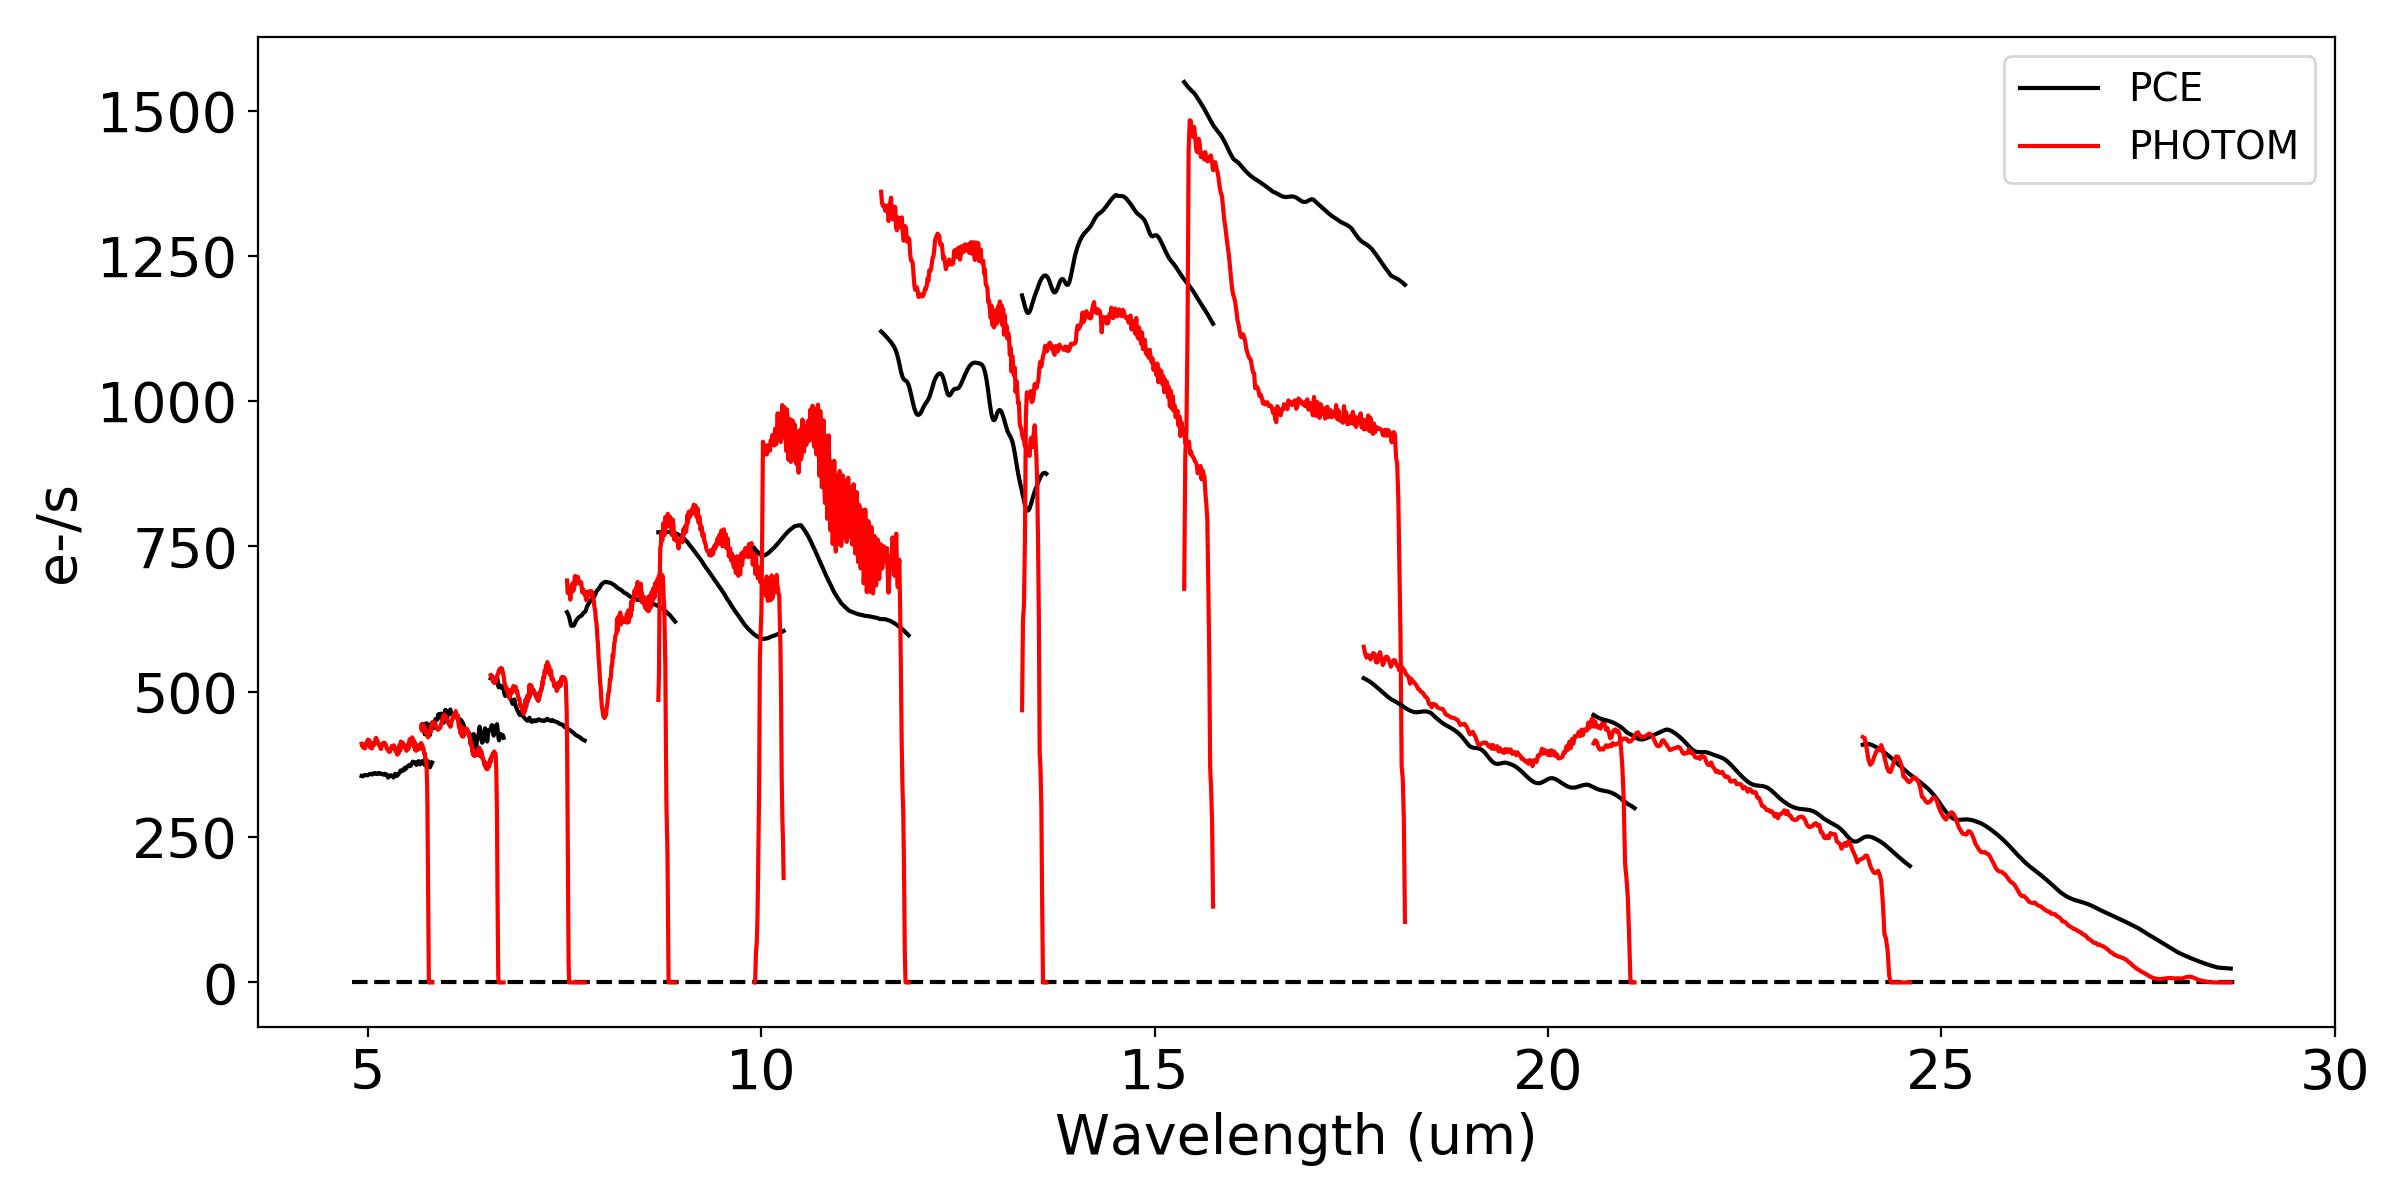

<IPython.core.display.Javascript object>


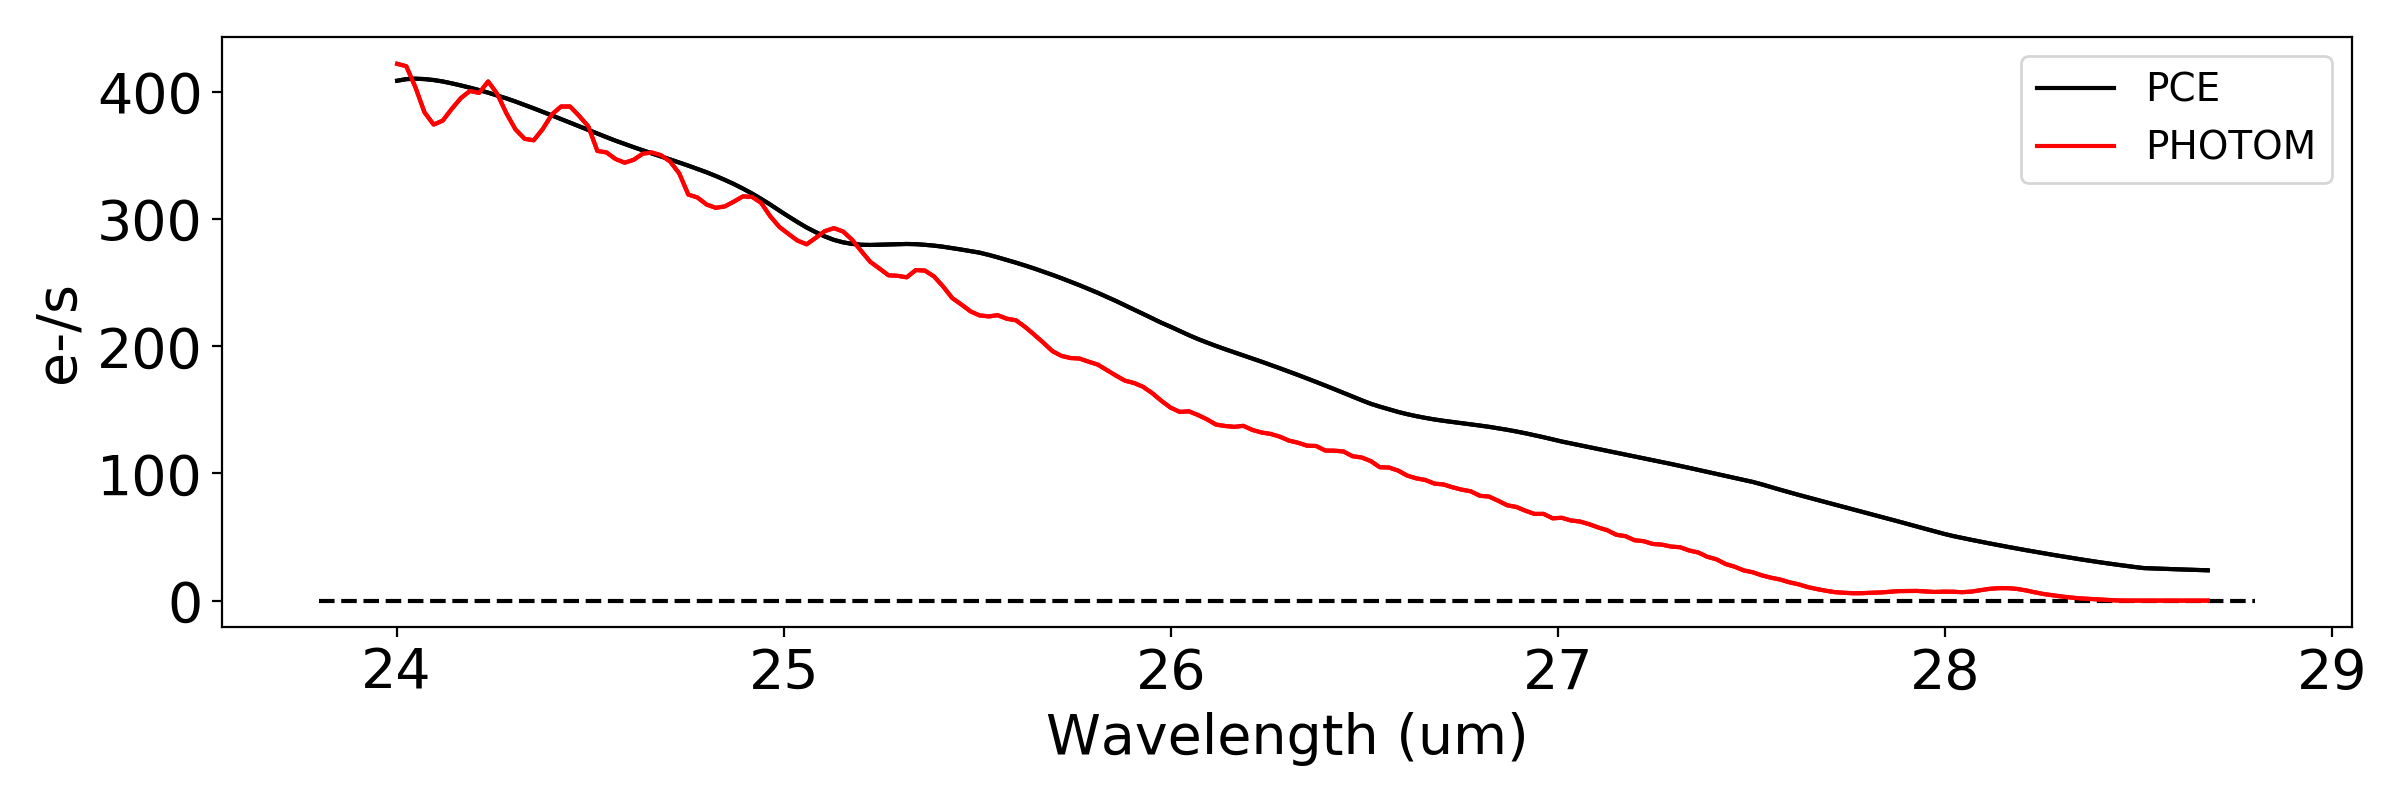

<IPython.core.display.Javascript object>


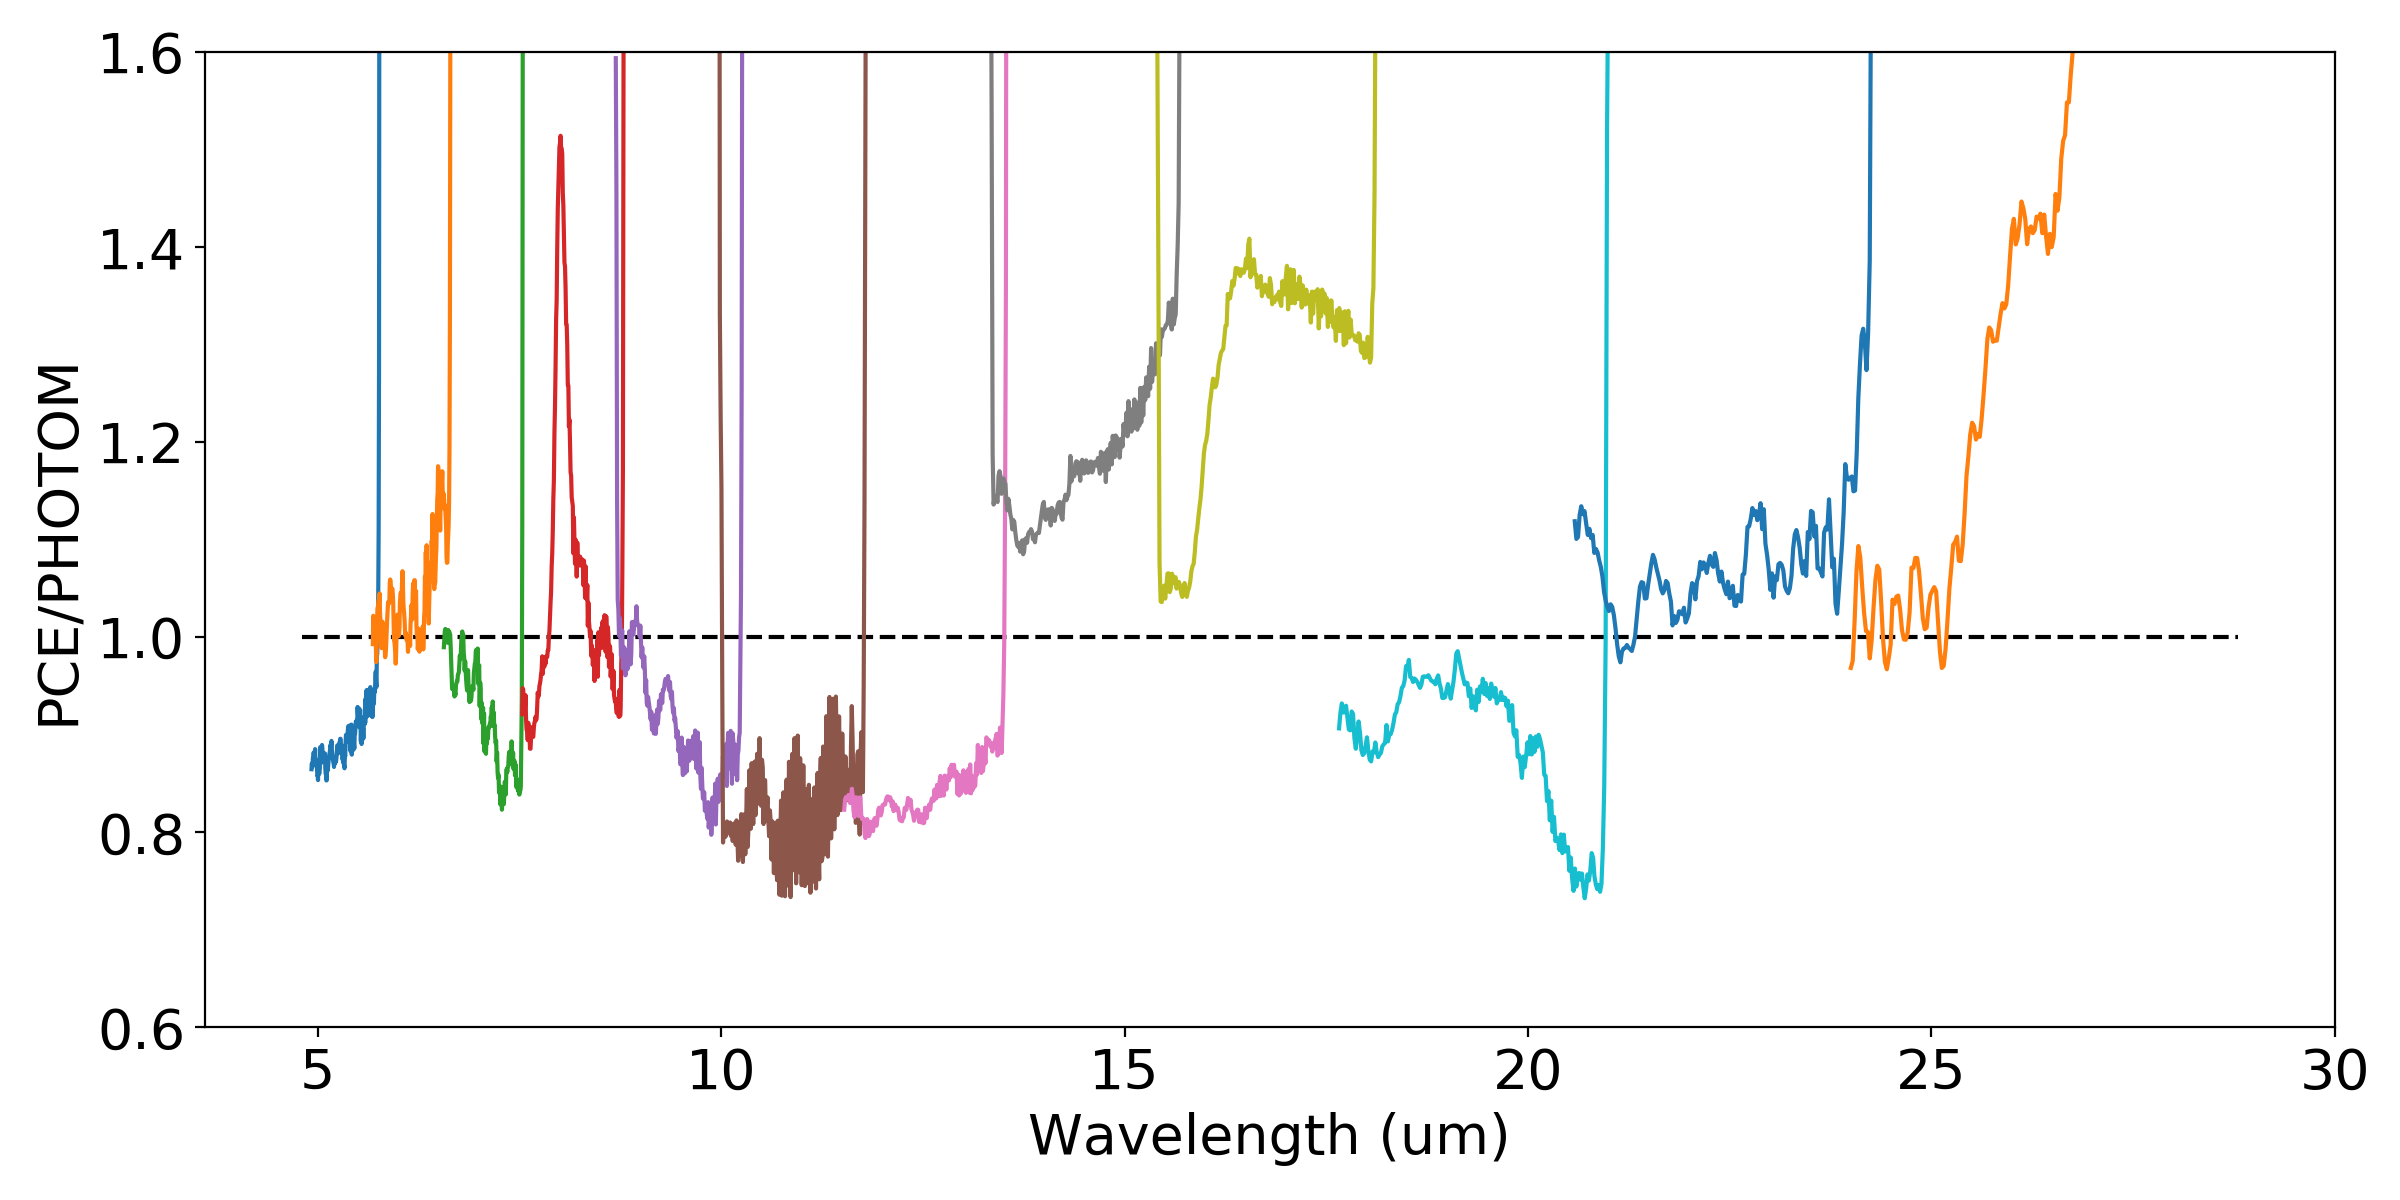

In [9]:
plt.figure(figsize=(12,6))
for band in bands[:-1]:
    plt.plot(lambdas[band],pce_erate[band],'k')
    plt.plot(lambdas[band],photom_binrate[band],'r')
plt.plot(lambdas[bands[-1]],pce_erate[bands[-1]],'k',label='PCE')
plt.plot(lambdas[bands[-1]],photom_binrate[bands[-1]],'r',label='PHOTOM')
plt.hlines(0,4.8,28.8,linestyle='dashed')
plt.xlabel('Wavelength (um)')
plt.ylabel('e-/s')
plt.legend(loc='upper right',fontsize=14)
plt.tight_layout()

plt.figure(figsize=(12,4))
for band in ['4C']:
    plt.plot(lambdas[band],pce_erate[band],'k')
    plt.plot(lambdas[band],photom_binrate[band],'r')
plt.plot(lambdas[bands[-1]],pce_erate[bands[-1]],'k',label='PCE')
plt.plot(lambdas[bands[-1]],photom_binrate[bands[-1]],'r',label='PHOTOM')
plt.hlines(0,23.8,28.8,linestyle='dashed')
plt.xlabel('Wavelength (um)')
plt.ylabel('e-/s')
plt.legend(loc='upper right',fontsize=14)
plt.tight_layout()

plt.figure(figsize=(12,6))
for band in bands:
    plt.plot(lambdas[band],pce_erate[band]/photom_binrate[band])
plt.hlines(1,4.8,28.8,linestyle='dashed')
# plt.hlines(0.55,4.8,28.8,linestyle='dashed',label='0.55 factor')
# plt.hlines(0.5,4.8,28.8,'r',linestyle='dashed',label='0.5 factor')
plt.ylim(0.6,1.6)
plt.xlabel('Wavelength (um)')
plt.ylabel('PCE/PHOTOM')
plt.legend(loc='lower right',fontsize=14)
plt.tight_layout()